In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor

events_holidays_df = pd.read_excel('/kaggle/input/walmart-sales-prediction-pune-march-2023/Events_HolidaysData.xlsx')
macro_economic_df = pd.read_excel('/kaggle/input/walmart-sales-prediction-pune-march-2023/macro_economic.xlsx')
weather_df = pd.read_excel('/kaggle/input/walmart-competition-preprocessed-dataset/WeatherData.xlsx', sheet_name=None)
weather_df = pd.concat(weather_df, ignore_index=True)
train_df = pd.read_csv('/kaggle/input/walmart-sales-prediction-pune-march-2023/train.csv')
submission = pd.read_csv('/kaggle/input/walmart-sales-prediction-pune-march-2023/submission.csv')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
weather_df['WeatherEvent'].fillna(0, inplace=True)
weather_df['WeatherEvent'].replace(to_replace=r'^[A-Za-z]', value=1, regex=True, inplace=True)
weather_df['WeatherEvent'].astype('int64')
weather_df.columns = ['Year', 'Month', 'Day', 'Temp high (°C)', 'Temp avg (°C)',
       'Temp low (°C)', 'Dew Point high (°C)', 'Dew Point avg (°C)',
       'Dew Point low (°C)', 'Humidity (%) high', 'Humidity (%) avg',
       'Humidity (%) low', 'Sea Level Press. (hPa) high',
       'Sea Level Press. (hPa) avg', 'Sea Level Press. (hPa) low',
       'Visibility (km) high', 'Visibility (km) avg', 'Visibility (km) low',
       'Wind (km/h) low', 'Wind (km/h) avg', 'Wind (km/h) high',
       'Precip. (mm) sum', 'WeatherEvent']
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

weather_df['Month'] = weather_df['Month'].map(month_mapping)
weather_df['date'] = pd.to_datetime(weather_df[['Year', 'Month']].assign(day=1))
event = weather_df.groupby(['date'])['WeatherEvent'].sum()
weather_df = weather_df[['date', 'Temp avg (°C)', 'Dew Point avg (°C)', 'Humidity (%) avg', 'Sea Level Press. (hPa) avg', 'Visibility (km) avg', 'Wind (km/h) avg']]
weather_df['Temp avg (°C)'] = weather_df['Temp avg (°C)'].apply(lambda x: float(x) if x!='-' else 0)
weather_df['Dew Point avg (°C)'] = weather_df['Dew Point avg (°C)'].apply(lambda x: float(x) if x!='-' else 0)
weather_df['Humidity (%) avg'] = weather_df['Humidity (%) avg'].apply(lambda x: float(x) if x!='-' else 0)
weather_df['Sea Level Press. (hPa) avg'] = weather_df['Sea Level Press. (hPa) avg'].apply(lambda x: float(x) if x!='-' else 0)
weather_df['Visibility (km) avg'] = weather_df['Visibility (km) avg'].apply(lambda x: float(x) if x!='-' else 0)
weather_df['Wind (km/h) avg'] = weather_df['Wind (km/h) avg'].apply(lambda x: float(x) if x!='-' else 0)
result = weather_df.groupby(['date']).mean()
result['WeatherEvent'] = event

In [3]:
events_holidays_df['MonthDate'] = events_holidays_df['MonthDate'].astype(str)
events_holidays_df['Month'] = events_holidays_df['MonthDate'].apply(lambda x: x.split('-')[1])
events_holidays_df['Month'] = events_holidays_df['Month'].astype(int)
events_holidays_df.drop(columns=['MonthDate', 'Event'], inplace=True)

In [4]:
events_holidays_df['date'] = pd.to_datetime(events_holidays_df[['Year', 'Month']].assign(day=1))
events_holidays_df.drop(columns=['Year', 'Month'], inplace=True)

In [5]:
events_holidays_df_dummies = pd.get_dummies(data=events_holidays_df, columns=['DayCategory'])
events_holidays_df_counted = events_holidays_df_dummies.groupby('date').sum()
events_holidays_df_counted.rename(columns={'DayCategory_Event': 'Number of Event Days', 'DayCategory_Federal Holiday': 'Number of Federal Holidays'}, inplace=True)
events_holidays_df_counted

,Number of Event Days,Number of Federal Holidays
date,,
2009-01-01,0,2
2009-02-01,1,1
2009-04-01,1,0
2009-05-01,1,1
2009-06-01,1,0
...,...,...
2016-07-01,0,1
2016-09-01,0,1
2016-10-01,1,1


In [6]:
len(macro_economic_df[macro_economic_df['AdvertisingExpenses (in Thousand Dollars)'] == '?']) / len(macro_economic_df['AdvertisingExpenses (in Thousand Dollars)']) # 89% of data is missing
macro_economic_df.drop(columns=['AdvertisingExpenses (in Thousand Dollars)'], inplace=True)

In [7]:
macro_economic_df['Year'] = macro_economic_df['Year-Month'].apply(lambda x: int(x.split('-')[0]))
macro_economic_df['Month'] = macro_economic_df['Year-Month'].apply(lambda x: x.split('-')[1])
macro_economic_df['Month'] = macro_economic_df['Month'].apply(lambda x: x.strip())
macro_economic_df['Month'].replace({'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct':10, 'Nov':11, 'Dec':12}, inplace=True)
macro_economic_df.drop(columns=['Year-Month'], inplace=True)


In [8]:
macro_economic_df
macro_economic_df['date'] = pd.to_datetime(macro_economic_df[['Year', 'Month']].assign(day=1))


In [9]:
macro_economic_df

,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,Year,Month,date
0,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,57.70,4.02,9.296,7.559,799,12.589,4.170,11.550,2009,1,2009-01-01
1,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,55.21,-4.32,9.296,7.559,799,12.589,3.870,11.100,2009,2,2009-02-01
2,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,51.50,-6.72,9.296,7.559,799,12.589,3.720,11.650,2009,3,2009-03-01
3,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,56.78,10.25,9.296,7.559,787,12.400,3.620,12.225,2009,4,2009-04-01
4,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,61.95,9.11,9.297,7.400,803,12.384,3.520,12.300,2009,5,2009-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,18741.599947,16797.206610,264.160,Democrats,4.9,12.51,9.64,25.52,80.26,-0.99,9.824,9.340,787,15.314,3.575,10.950,2016,8,2016-08-01
92,18840.309646,16852.562745,264.602,Democrats,4.9,12.51,9.64,25.74,77.86,-2.99,9.950,9.464,790,15.580,3.475,10.950,2016,9,2016-09-01
93,18740.780023,16725.460098,264.738,Democrats,4.8,12.51,9.64,26.04,78.52,0.85,9.950,9.464,785,15.472,3.475,11.425,2016,10,2016-10-01
94,18960.461568,16910.896330,265.203,Democrats,4.6,12.41,9.45,25.87,78.92,0.51,9.950,9.464,791,15.600,3.475,11.425,2016,11,2016-11-01


In [10]:
train_df['date'] = pd.to_datetime(train_df[['Year', 'Month']].assign(day=1))
train_df.drop(columns=['Year', 'Month'], inplace=True)
train_df = train_df.merge(result, on='date')
train_df = train_df.merge(macro_economic_df, on='date')
train_df = train_df.merge(events_holidays_df_counted, on='date', how='left')
train_df.fillna(0, inplace=True)
train_df['date'] = train_df.date.dt.to_period('M')
train_df.set_index('date', inplace=True)
train_df.drop(columns=['Year', 'Month'], inplace=True)

In [11]:
train_df

,ProductCategory,Sales(In ThousandDollars),Temp avg (°C),Dew Point avg (°C),Humidity (%) avg,Sea Level Press. (hPa) avg,Visibility (km) avg,Wind (km/h) avg,WeatherEvent,Monthly Nominal GDP Index (inMillion$),...,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,Number of Event Days,Number of Federal Holidays
date,,,,,,,,,,,,,,,,,,,,,
2009-01,WomenClothing,1755.0,-2.096774,-9.903226,57.354839,1015.967742,14.000000,12.000000,10,14421.752895,...,57.70,4.02,9.296,7.559,799,12.589,4.17,11.55,0.0,2.0
2009-01,MenClothing,524.0,-2.096774,-9.903226,57.354839,1015.967742,14.000000,12.000000,10,14421.752895,...,57.70,4.02,9.296,7.559,799,12.589,4.17,11.55,0.0,2.0
2009-01,OtherClothing,936.0,-2.096774,-9.903226,57.354839,1015.967742,14.000000,12.000000,10,14421.752895,...,57.70,4.02,9.296,7.559,799,12.589,4.17,11.55,0.0,2.0
2009-02,WomenClothing,1729.0,2.785714,-6.392857,54.000000,1017.071429,15.178571,12.214286,6,14389.200466,...,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.10,1.0,1.0
2009-02,MenClothing,496.0,2.785714,-6.392857,54.000000,1017.071429,15.178571,12.214286,6,14389.200466,...,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.10,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11,MenClothing,798.0,7.500000,-1.966667,53.066667,1021.400000,14.766667,10.033333,10,17053.738107,...,84.65,-5.26,10.136,7.582,790,12.479,3.58,9.65,0.0,2.0
2013-11,OtherClothing,1209.0,7.500000,-1.966667,53.066667,1021.400000,14.766667,10.033333,10,17053.738107,...,84.65,-5.26,10.136,7.582,790,12.479,3.58,9.65,0.0,2.0
2013-12,WomenClothing,4865.0,3.709677,-3.000000,61.903226,1019.225806,12.935484,9.419355,11,17061.071077,...,87.49,3.35,10.136,7.582,788,12.443,3.58,9.65,2.0,1.0


In [12]:
test_df = result.merge(macro_economic_df, on='date')
test_df = test_df.merge(events_holidays_df_counted, on='date', how='left')
test_df.fillna(0, inplace=True)

test_df.set_index('date', inplace=True)
test_df.drop(columns=['Year', 'Month'], inplace=True)
test_df_2014 = test_df[60:]

In [13]:
women_clothing_df = train_df[train_df['ProductCategory']=='WomenClothing']
men_clothing_df = train_df[train_df['ProductCategory']=='MenClothing']
other_clothing_df = train_df[train_df['ProductCategory']=='OtherClothing']

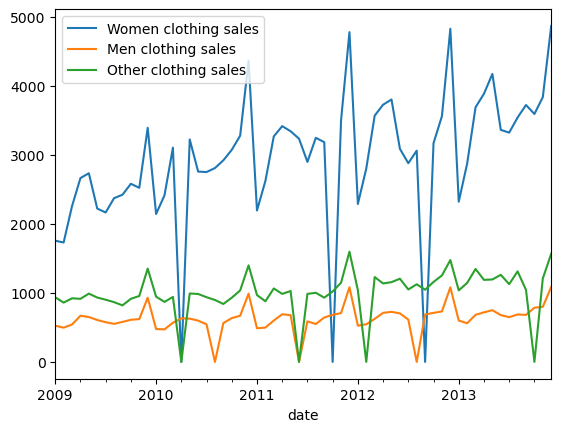

In [14]:
ax = women_clothing_df.plot(y='Sales(In ThousandDollars)', label='Women clothing sales')
men_clothing_df.plot(y='Sales(In ThousandDollars)', ax=ax, label='Men clothing sales')
other_clothing_df.plot(y='Sales(In ThousandDollars)', ax=ax, label='Other clothing sales')
plt.show()

In [15]:
women_sales_outliers = women_clothing_df.index[women_clothing_df['Sales(In ThousandDollars)'] == 0].tolist()
women_clothing_df.loc[women_clothing_df.index.isin(women_sales_outliers), 'Sales(In ThousandDollars)'] = np.nan
women_clothing_df['Sales(In ThousandDollars)']= np.where((women_clothing_df['Sales(In ThousandDollars)'].isnull()) & (women_clothing_df.index.isin(women_sales_outliers)), women_clothing_df['Sales(In ThousandDollars)'].interpolate(),women_clothing_df['Sales(In ThousandDollars)'])

men_sales_outliers = men_clothing_df.index[men_clothing_df['Sales(In ThousandDollars)'] == 0].tolist()
men_clothing_df.loc[men_clothing_df.index.isin(men_sales_outliers), 'Sales(In ThousandDollars)'] = np.nan
men_clothing_df['Sales(In ThousandDollars)']= np.where((men_clothing_df['Sales(In ThousandDollars)'].isnull()) & (men_clothing_df.index.isin(men_sales_outliers)), men_clothing_df['Sales(In ThousandDollars)'].interpolate(),men_clothing_df['Sales(In ThousandDollars)'])

other_sales_outliers = other_clothing_df.index[other_clothing_df['Sales(In ThousandDollars)'] == 0].tolist()
other_clothing_df.loc[other_clothing_df.index.isin(other_sales_outliers), 'Sales(In ThousandDollars)'] = np.nan
other_clothing_df['Sales(In ThousandDollars)']= np.where((other_clothing_df['Sales(In ThousandDollars)'].isnull()) & (other_clothing_df.index.isin(other_sales_outliers)), other_clothing_df['Sales(In ThousandDollars)'].interpolate(), other_clothing_df['Sales(In ThousandDollars)'])

/tmp/ipykernel_21/1992356991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_clothing_df['Sales(In ThousandDollars)']= np.where((women_clothing_df['Sales(In ThousandDollars)'].isnull()) & (women_clothing_df.index.isin(women_sales_outliers)), women_clothing_df['Sales(In ThousandDollars)'].interpolate(),women_clothing_df['Sales(In ThousandDollars)'])
/tmp/ipykernel_21/1992356991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_clothing_df['Sales(In ThousandDollars)']= np.where((men_clothing_d

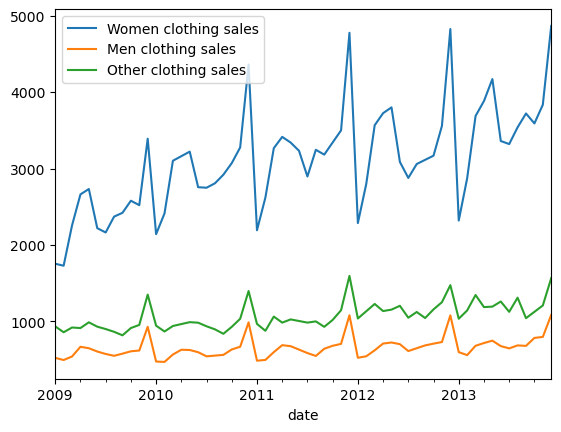

In [16]:
ax = women_clothing_df.plot(y='Sales(In ThousandDollars)', label='Women clothing sales')
men_clothing_df.plot(y='Sales(In ThousandDollars)', ax=ax, label='Men clothing sales')
other_clothing_df.plot(y='Sales(In ThousandDollars)', ax=ax, label='Other clothing sales')
plt.show()

/tmp/ipykernel_21/520594112.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


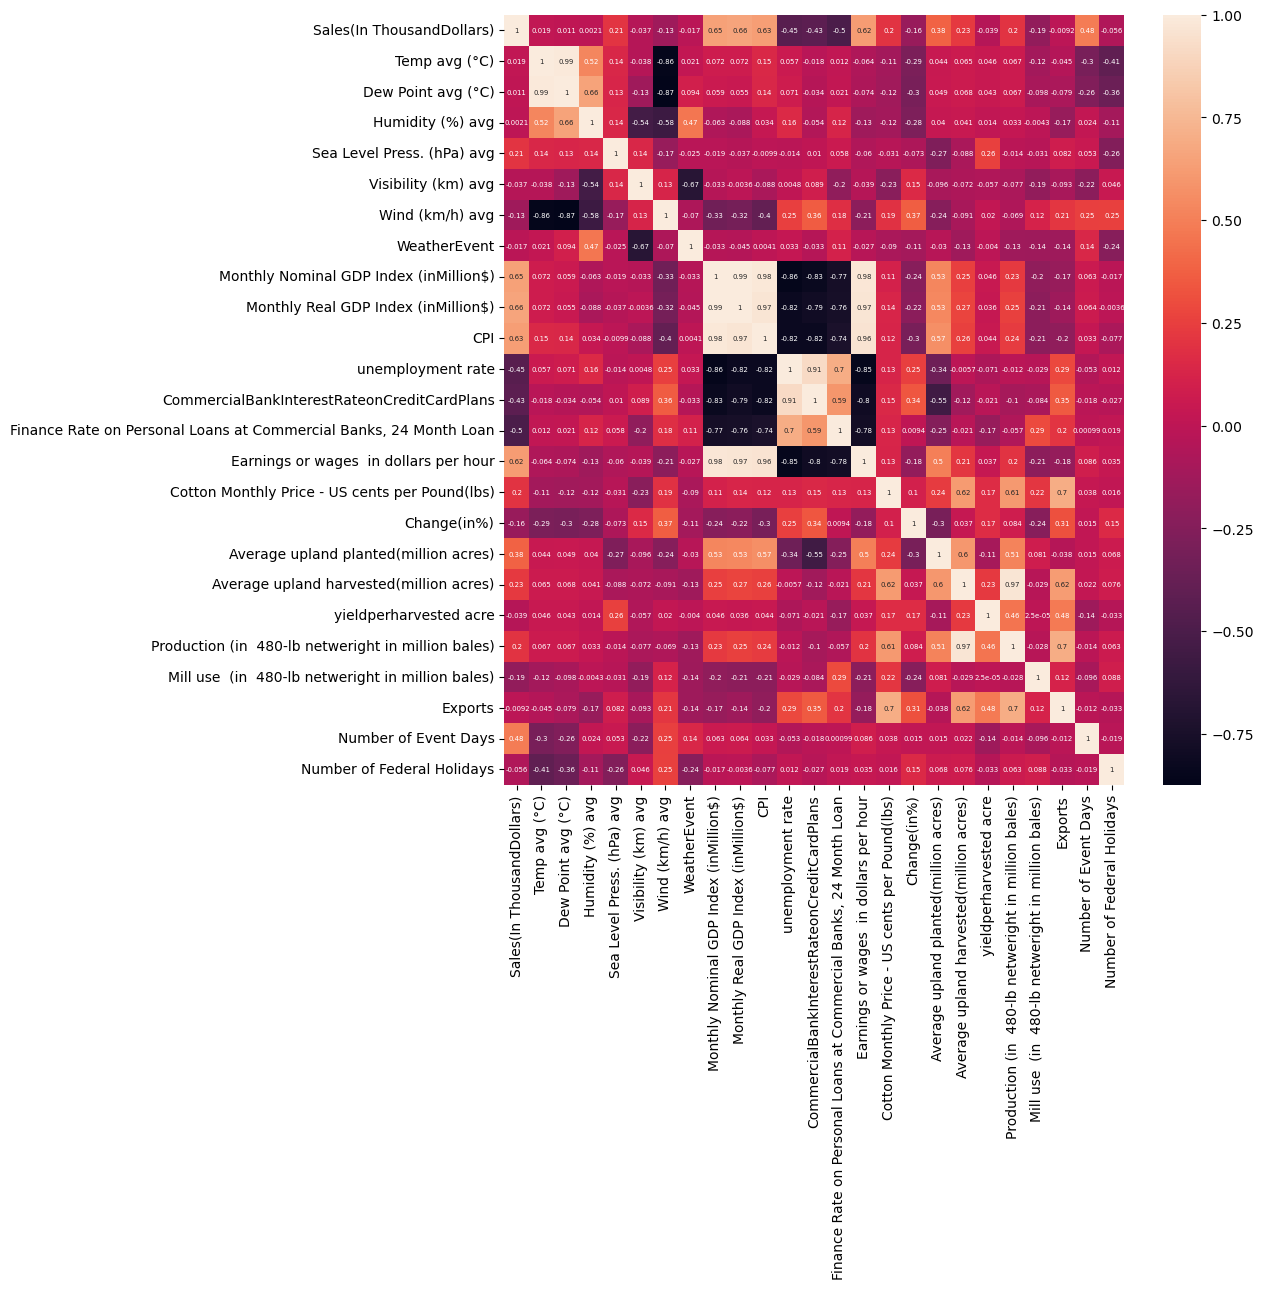

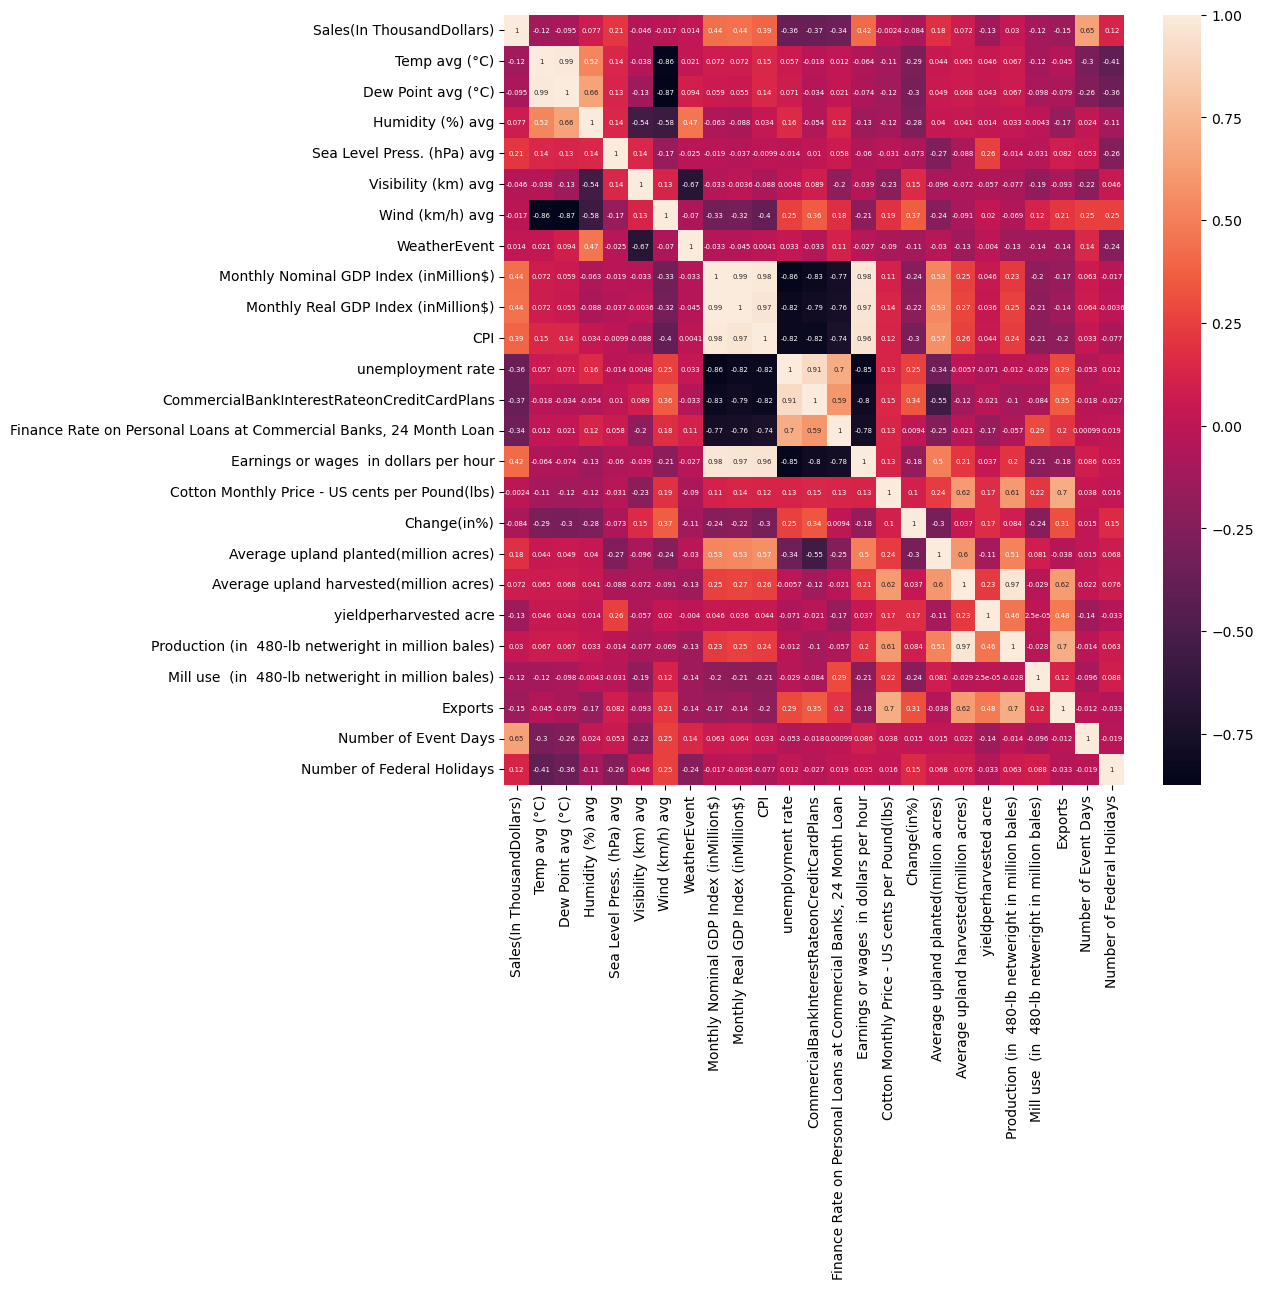

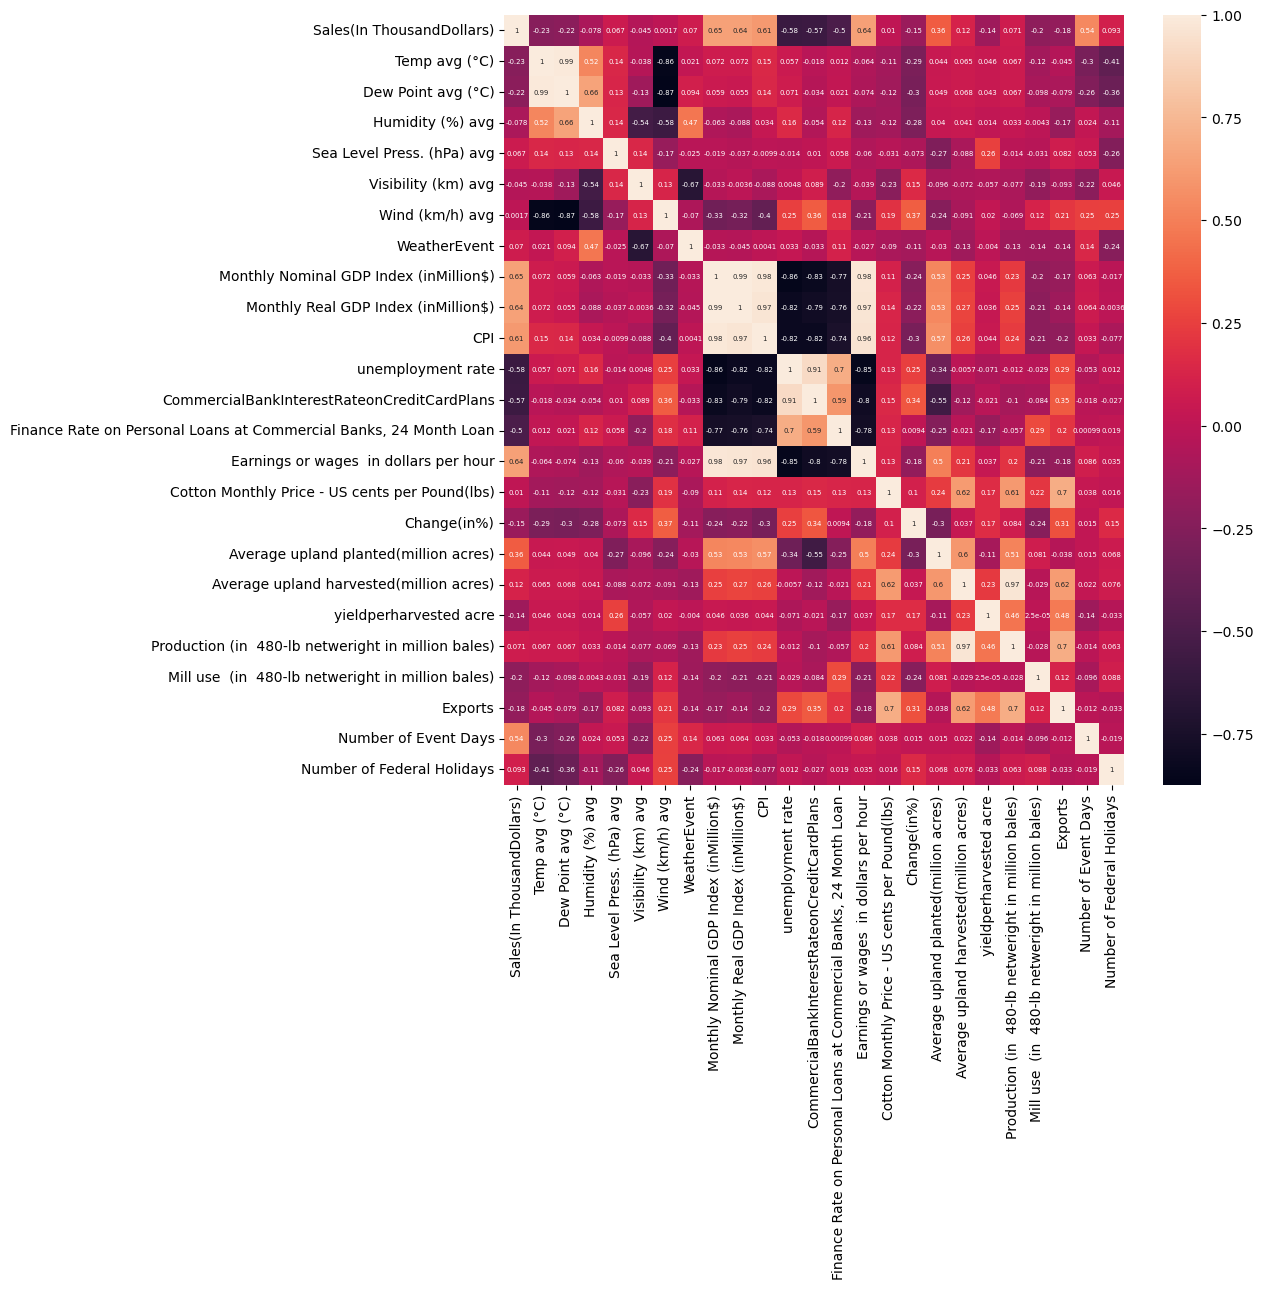

In [17]:
corr_matrices = []
for df in [women_clothing_df, men_clothing_df, other_clothing_df]:
  corr_matrix = df.corr()
  fig, ax = plt.subplots(figsize=(10,10))
  sn.heatmap(corr_matrix, annot=True, annot_kws={"size": 5}, ax=ax)
  corr_matrices.append(corr_matrix)

In [18]:
corr_matrices[0]

,Sales(In ThousandDollars),Temp avg (°C),Dew Point avg (°C),Humidity (%) avg,Sea Level Press. (hPa) avg,Visibility (km) avg,Wind (km/h) avg,WeatherEvent,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),...,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,Number of Event Days,Number of Federal Holidays
Sales(In ThousandDollars),1.000000,0.018503,0.010605,0.002080,0.209254,-0.036641,-0.133335,-0.016771,0.645168,0.657165,...,0.201108,-0.161526,0.382296,0.227494,-0.039483,0.197188,-0.186991,-0.009239,0.482162,-0.055635
Temp avg (°C),0.018503,1.000000,0.985474,0.524618,0.141299,-0.037769,-0.858041,0.021214,0.071768,0.072431,...,-0.113646,-0.285461,0.044138,0.065085,0.046369,0.066564,-0.117435,-0.045424,-0.297297,-0.407617
Dew Point avg (°C),0.010605,0.985474,1.000000,0.655866,0.132469,-0.132156,-0.874200,0.093946,0.059295,0.055319,...,-0.122536,-0.301247,0.048907,0.067613,0.042725,0.066808,-0.097554,-0.078569,-0.264439,-0.357291
Humidity (%) avg,0.002080,0.524618,0.655866,1.000000,0.139480,-0.541986,-0.576945,0.465066,-0.062800,-0.087531,...,-0.119132,-0.280894,0.040356,0.041264,0.013726,0.033193,-0.004344,-0.170138,0.023563,-0.110886
Sea Level Press. (hPa) avg,0.209254,0.141299,0.132469,0.139480,1.000000,0.141068,-0.169161,-0.024820,-0.018933,-0.036705,...,-0.031406,-0.072905,-0.266604,-0.087891,0.260503,-0.014336,-0.031255,0.081682,0.052793,-0.258344
Visibility (km) avg,-0.036641,-0.037769,-0.132156,-0.541986,0.141068,1.000000,0.128250,-0.673577,-0.032609,-0.003576,...,-0.228062,0.151281,-0.095633,-0.071696,-0.057140,-0.077172,-0.186680,-0.092638,-0.216236,0.046249
Wind (km/h) avg,-0.133335,-0.858041,-0.874200,-0.576945,-0.169161,0.128250,1.000000,-0.070315,-0.333362,-0.316525,...,0.188174,0.366397,-0.244365,-0.090897,0.020027,-0.068727,0.121400,0.211938,0.248706,0.254670
WeatherEvent,-0.016771,0.021214,0.093946,0.465066,-0.024820,-0.673577,-0.070315,1.000000,-0.032572,-0.045119,...,-0.089554,-0.108086,-0.030455,-0.133960,-0.003972,-0.127451,-0.137956,-0.137443,0.142650,-0.236638
Monthly Nominal GDP Index (inMillion$),0.645168,0.071768,0.059295,-0.062800,-0.018933,-0.032609,-0.333362,-0.032572,1.000000,0.994817,...,0.108554,-0.235840,0.525076,0.246664,0.046461,0.229896,-0.195745,-0.168890,0.062813,-0.016763
Monthly Real GDP Index (inMillion$),0.657165,0.072431,0.055319,-0.087531,-0.036705,-0.003576,-0.316525,-0.045119,0.994817,1.000000,...,0.135499,-0.219430,0.532605,0.274493,0.036087,0.253858,-0.214783,-0.135842,0.064281,-0.003557


In [19]:
columns = []
for mx in corr_matrices:
  columns.append(mx[(mx['Sales(In ThousandDollars)'] > 0.08) | (mx['Sales(In ThousandDollars)'] < -0.08)].index.values)

In [20]:
women_clothing_df = women_clothing_df[columns[0]]
men_clothing_df = men_clothing_df[columns[1]]
other_clothing_df = other_clothing_df[columns[2]]

In [21]:
print(other_clothing_df.shape)

(60, 18)


In [22]:
corr_matrices[1]['Sales(In ThousandDollars)'].sort_values()

CommercialBankInterestRateonCreditCardPlans                         -0.370182
unemployment rate                                                   -0.364474
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan   -0.340115
Exports                                                             -0.146108
yieldperharvested acre                                              -0.128960
Temp avg (°C)                                                       -0.123630
Mill use  (in  480-lb netweright in million bales)                  -0.119700
Dew Point avg (°C)                                                  -0.095165
Change(in%)                                                         -0.084148
Visibility (km) avg                                                 -0.046038
Wind (km/h) avg                                                     -0.016880
Cotton Monthly Price - US cents per Pound(lbs)                      -0.002431
WeatherEvent                                                    

In [23]:
num_features = 2

w_sorted_features = corr_matrices[0]['Sales(In ThousandDollars)'].apply(lambda x: abs(x)).sort_values()
w_best_features = w_sorted_features[-num_features:].index
w_best_features = w_best_features.drop('Sales(In ThousandDollars)')

m_sorted_features = corr_matrices[1]['Sales(In ThousandDollars)'].apply(lambda x: abs(x)).sort_values()
m_best_features = m_sorted_features[-num_features:].index
m_best_features = m_best_features.drop('Sales(In ThousandDollars)')

o_sorted_features = corr_matrices[2]['Sales(In ThousandDollars)'].apply(lambda x: abs(x)).sort_values()
o_best_features = o_sorted_features[-num_features:].index
o_best_features = o_best_features.drop('Sales(In ThousandDollars)')

In [24]:
print(w_best_features)
print(m_best_features)
print(o_best_features)

Index(['Monthly Real GDP Index (inMillion$)'], dtype='object')
Index(['Number of Event Days'], dtype='object')
Index(['Monthly Nominal GDP Index (inMillion$)'], dtype='object')


In [25]:
predict_data_women = pd.DataFrame()
predict_data_women['ds'] = women_clothing_df.index.values
predict_data_women['y'] = women_clothing_df['Sales(In ThousandDollars)'].values
for feature in w_best_features:
  predict_data_women[feature] = women_clothing_df[feature].values
predict_data_women['ds'] = predict_data_women['ds'].dt.to_timestamp()

predict_data_men = pd.DataFrame()
predict_data_men['ds'] = men_clothing_df.index.values
predict_data_men['y'] = men_clothing_df['Sales(In ThousandDollars)'].values
for feature in m_best_features:
  predict_data_men[feature] = men_clothing_df[feature].values
predict_data_men['ds'] = predict_data_men['ds'].dt.to_timestamp()

predict_data_other = pd.DataFrame()
predict_data_other['ds'] = other_clothing_df.index.values
predict_data_other['y'] = other_clothing_df['Sales(In ThousandDollars)'].values
for feature in o_best_features:
  predict_data_other[feature] = other_clothing_df[feature].values
predict_data_other['ds'] = predict_data_other['ds'].dt.to_timestamp()

In [26]:
prophet_women = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                yearly_seasonality=True
            )
prophet_women.add_country_holidays(country_name='US')
prophet_women.fit(predict_data_women)

prophet_men = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                yearly_seasonality=True)
prophet_men.add_country_holidays(country_name='US')
prophet_men.fit(predict_data_men)

prophet_other = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                yearly_seasonality=True)
prophet_other.add_country_holidays(country_name='US')
prophet_other.fit(predict_data_other)

17:17:14 - cmdstanpy - INFO - Chain [1] start processing
17:17:15 - cmdstanpy - INFO - Chain [1] done processing
17:17:15 - cmdstanpy - INFO - Chain [1] start processing
17:17:16 - cmdstanpy - INFO - Chain [1] done processing
17:17:16 - cmdstanpy - INFO - Chain [1] start processing
17:17:17 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
test_df.columns

Index(['Temp avg (°C)', 'Dew Point avg (°C)', 'Humidity (%) avg',
       'Sea Level Press. (hPa) avg', 'Visibility (km) avg', 'Wind (km/h) avg',
       'WeatherEvent', 'Monthly Nominal GDP Index (inMillion$)',
       'Monthly Real GDP Index (inMillion$)', 'CPI', 'PartyInPower',
       'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans',
       'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan',
       'Earnings or wages  in dollars per hour',
       'Cotton Monthly Price - US cents per Pound(lbs)', 'Change(in%)',
       'Average upland planted(million acres)',
       'Average upland harvested(million acres)', 'yieldperharvested acre',
       'Production (in  480-lb netweright in million bales)',
       'Mill use  (in  480-lb netweright in million bales)', 'Exports',
       'Number of Event Days', 'Number of Federal Holidays'],
      dtype='object')

In [28]:
future_sales_w = test_df#[w_best_features]
future_sales_w['ds'] = test_df.index.values

forecast_women = prophet_women.predict(future_sales_w)
forecast_women[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_women.index = forecast_women['ds']

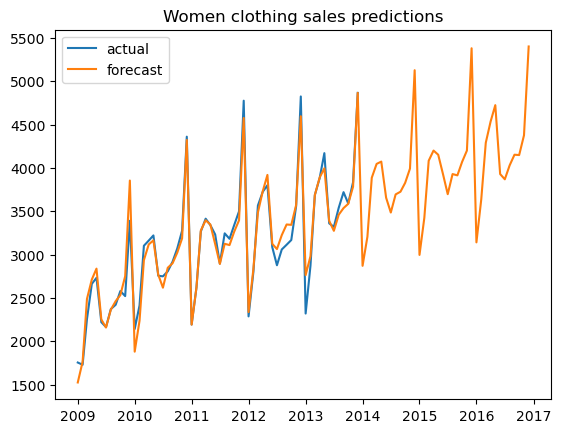

In [29]:
plt.plot(predict_data_women['ds'], predict_data_women['y'], label='actual')
plt.plot(forecast_women['yhat'], label='forecast')
plt.title('Women clothing sales predictions')
plt.legend()
plt.show()

In [30]:
future_sales_m = test_df#[m_best_features]
future_sales_m['ds'] = test_df.index.values

forecast_men = prophet_men.predict(future_sales_m)
forecast_men[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_men.index = forecast_men['ds']

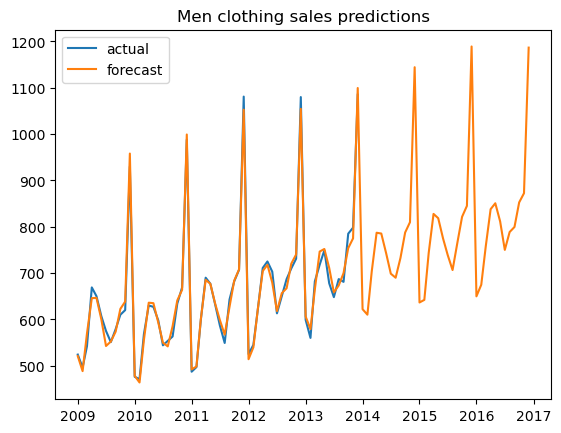

In [31]:
plt.plot(predict_data_men['ds'], predict_data_men['y'], label='actual')
plt.plot(forecast_men['yhat'], label='forecast')
plt.title('Men clothing sales predictions')
plt.legend()
plt.show()

In [32]:
future_sales_o = test_df#[o_best_features]
future_sales_o['ds'] = test_df.index.values

forecast_other = prophet_other.predict(future_sales_o)
forecast_other[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_other.index = forecast_other['ds']

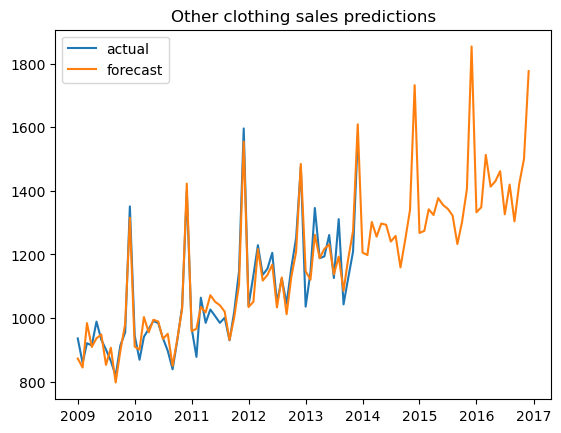

In [33]:
plt.plot(predict_data_other['ds'], predict_data_other['y'], label='actual')
plt.plot(forecast_other['yhat'], label='forecast')
plt.title('Other clothing sales predictions')
plt.legend()
plt.show()

In [34]:
forecast_women = forecast_women[forecast_women['ds'].dt.year<2015].reset_index(drop=True)
forecast_women.loc[:59,'yhat'] = predict_data_women['y']
df_w = forecast_women.merge(test_df, left_on='ds', right_on='date')
df_w.rename(columns={'ds_x': 'ds'}, inplace=True)
df_w.drop(columns=['ds_y'], inplace=True)

forecast_men = forecast_men[forecast_men['ds'].dt.year<2015].reset_index(drop=True)
forecast_men.loc[:59,'yhat'] = predict_data_men['y']
df_m = forecast_men.merge(test_df, left_on='ds', right_on='date')
df_m.rename(columns={'ds_x': 'ds'}, inplace=True)
df_m.drop(columns=['ds_y'], inplace=True)

forecast_other = forecast_other[forecast_other['ds'].dt.year<2015].reset_index(drop=True)
forecast_other.loc[:59,'yhat'] = predict_data_other['y']
df_o = forecast_other.merge(test_df, left_on='ds', right_on='date')
df_o.rename(columns={'ds_x': 'ds'}, inplace=True)
df_o.drop(columns=['ds_y'], inplace=True)

In [35]:
# lags=[1, 2, 3, 4, 5]

#for lag in lags:
#    df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
df_w = df_w.dropna(axis=0, how='any')

X_w = df_w[['yhat', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper','additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'Humidity (%) avg', 'Sea Level Press. (hPa) avg', 'Wind (km/h) avg', 'Monthly Nominal GDP Index (inMillion$)', 'Monthly Real GDP Index (inMillion$)', 'CPI', 'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans', 'ds']]
y_w = df_w[['yhat', 'ds']]

X_train_w, X_test_w = X_w[X_w['ds'].dt.year<2014], X_w[X_w['ds'].dt.year>2013]
y_train_w, y_test_w = y_w[y_w['ds'].dt.year<2014], y_w[y_w['ds'].dt.year>2013]


df_m = df_m.dropna(axis=0, how='any')

X_m = df_m[['yhat', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper','additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'Humidity (%) avg', 'Sea Level Press. (hPa) avg', 'Wind (km/h) avg', 'Monthly Nominal GDP Index (inMillion$)', 'Monthly Real GDP Index (inMillion$)', 'CPI', 'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans', 'ds']]
y_m = df_m[['yhat', 'ds']]

X_train_m, X_test_m = X_m[X_m['ds'].dt.year<2014], X_m[X_m['ds'].dt.year>2013]
y_train_m, y_test_m = y_m[y_m['ds'].dt.year<2014], y_m[y_m['ds'].dt.year>2013]


df_o = df_o.dropna(axis=0, how='any')

X_o = df_o[['yhat', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper','additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'Humidity (%) avg', 'Sea Level Press. (hPa) avg', 'Wind (km/h) avg', 'Monthly Nominal GDP Index (inMillion$)', 'Monthly Real GDP Index (inMillion$)', 'CPI', 'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans', 'ds']]
y_o = df_o[['yhat', 'ds']]

X_train_o, X_test_o = X_o[X_o['ds'].dt.year<2014], X_o[X_o['ds'].dt.year>2013]
y_train_o, y_test_o = y_o[y_o['ds'].dt.year<2014], y_o[y_o['ds'].dt.year>2013]

X_train_w.drop(columns=['ds'], inplace=True)
X_test_w.drop(columns=['ds'], inplace=True)
y_train_w.drop(columns=['ds'], inplace=True)
y_test_w.drop(columns=['ds'], inplace=True)

X_train_m.drop(columns=['ds'], inplace=True)
X_test_m.drop(columns=['ds'], inplace=True)
y_train_m.drop(columns=['ds'], inplace=True)
y_test_m.drop(columns=['ds'], inplace=True)

X_train_o.drop(columns=['ds'], inplace=True)
X_test_o.drop(columns=['ds'], inplace=True)
y_train_o.drop(columns=['ds'], inplace=True)
y_test_o.drop(columns=['ds'], inplace=True)

/tmp/ipykernel_21/2188647651.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_w.drop(columns=['ds'], inplace=True)
/tmp/ipykernel_21/2188647651.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_w.drop(columns=['ds'], inplace=True)
/tmp/ipykernel_21/2188647651.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_w.drop(columns=['ds'], inplace=True)
/tmp/ipykernel_21/2188647651.py:40: SettingWithCopyWarning:

In [36]:
gradient_boosting_women = GradientBoostingRegressor(random_state=42)
gradient_boosting_women.fit(X_train_w, y_train_w)
predictions_w = gradient_boosting_women.predict(X_test_w)

gradient_boosting_men = GradientBoostingRegressor(random_state=42)
gradient_boosting_men.fit(X_train_m, y_train_m)
predictions_m = gradient_boosting_men.predict(X_test_m)

gradient_boosting_other = GradientBoostingRegressor(random_state=42)
gradient_boosting_other.fit(X_train_o, y_train_o)
predictions_o = gradient_boosting_other.predict(X_test_o)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


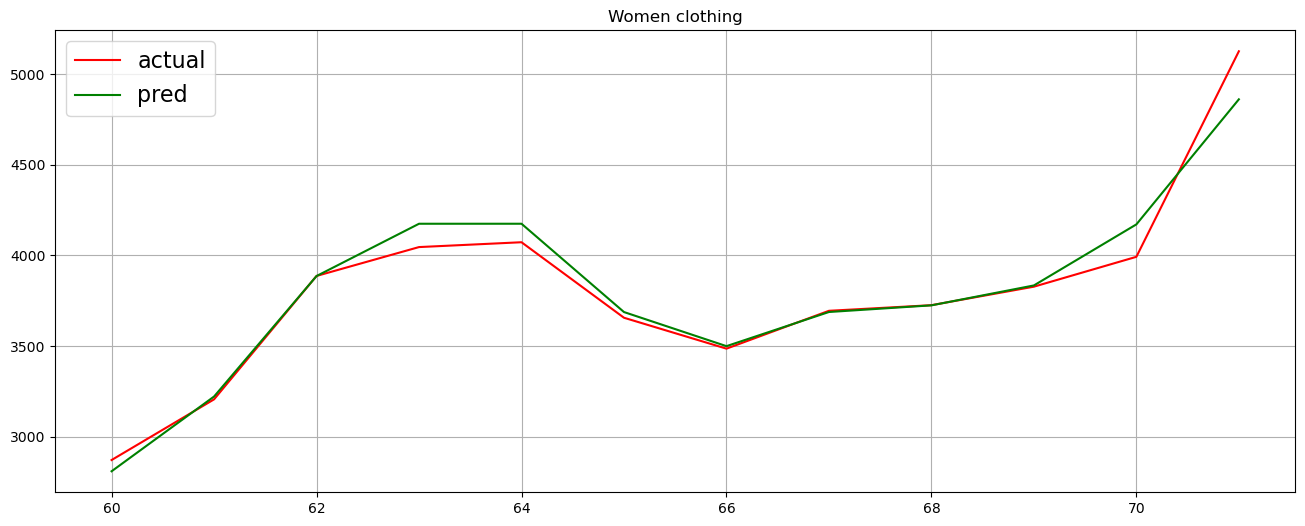

In [37]:
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.plot(y_test_w, color='red')
plt.plot(pd.Series(predictions_w, index=y_test_w.index), color='green')
plt.legend(labels=['actual', 'pred'], fontsize=16)
plt.title('Women clothing')
plt.grid()
plt.show()

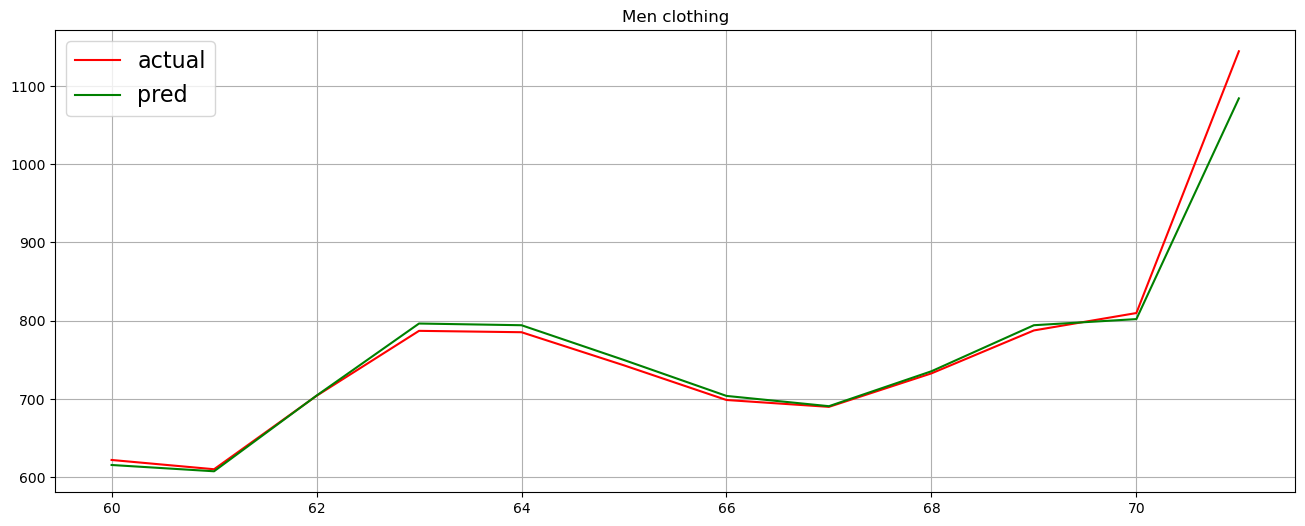

In [38]:
fig = plt.figure(figsize=(16,6))
plt.plot(y_test_m, color='red')
plt.plot(pd.Series(predictions_m, index=y_test_m.index), color='green')
plt.legend(labels=['actual', 'pred'], fontsize=16)
plt.title('Men clothing')
plt.grid()
plt.show()

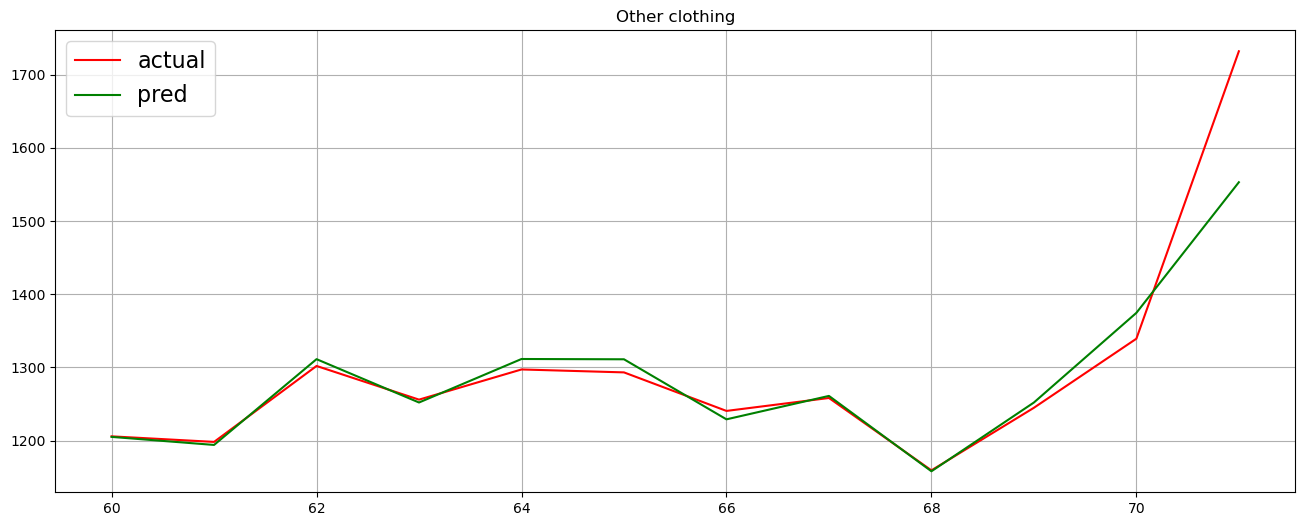

In [39]:
fig = plt.figure(figsize=(16,6))
plt.plot(y_test_o, color='red')
plt.plot(pd.Series(predictions_o, index=y_test_o.index), color='green')
plt.legend(labels=['actual', 'pred'], fontsize=16)
plt.title('Other clothing')
plt.grid()
plt.show()

In [40]:
submission_to_predict = submission[['Year', 'Month', 'ProductCategory']]
submission_to_predict['date'] = pd.to_datetime(submission_to_predict[['Year', 'Month']].assign(day=1))
submission_to_predict.drop(columns=['Year', 'Month'], inplace=True)

submission_to_predict_women = submission_to_predict[submission_to_predict['ProductCategory']=='WomenClothing']
submission_to_predict_men = submission_to_predict[submission_to_predict['ProductCategory']=='MenClothing']
submission_to_predict_other = submission_to_predict[submission_to_predict['ProductCategory']=='OtherClothing']

submission_to_predict_women['Sales(In ThousandDollars)'] = predictions_w
submission_to_predict_men['Sales(In ThousandDollars)'] = predictions_m
submission_to_predict_other['Sales(In ThousandDollars)'] = predictions_o

submission = pd.DataFrame(columns=['date', 'Sales(In ThousandDollars)', 'ProductCategory'])
submission = pd.concat([submission_to_predict_women,submission_to_predict_men,submission_to_predict_other])

custom_order = ["WomenClothing", "MenClothing", "OtherClothing"]
cat_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
submission["ProductCategory"] = submission["ProductCategory"].astype(cat_dtype)
submission = submission.sort_values(by=['date', 'ProductCategory'])
submission['Year'] = submission['date'].dt.year
submission.drop(columns=['date', 'ProductCategory'], inplace=True)
submission.reset_index(inplace=True)
submission.drop(columns=['index', 'Year'], inplace=True)
submission.index.names = ['Year']
submission.index = pd.RangeIndex(start=1, stop=37, step=1, name='Year')

/tmp/ipykernel_21/3527732706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_to_predict['date'] = pd.to_datetime(submission_to_predict[['Year', 'Month']].assign(day=1))
/tmp/ipykernel_21/3527732706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_to_predict.drop(columns=['Year', 'Month'], inplace=True)
/tmp/ipykernel_21/3527732706.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [41]:
submission

,Sales(In ThousandDollars)
Year,
1,2808.306792
2,615.585202
3,1204.980997
4,3220.938415
5,607.549247
6,1193.994321
7,3886.004634
8,704.269492
9,1311.216148


In [42]:
submission.to_csv('submission.csv')